# Machine Learning Homework 01

We will start by importing the required packages:

In [9]:
import math
from timeit import timeit
from typing import Tuple

import numpy as np
from numpy.random import rand
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris, load_breast_cancer, load_digits
from tqdm import tqdm

## Problem 01

Problem 01 requires computing pairwise Euclidean distances between row vectors in matrices.

There are two subproblems here: 

1. compute the pairwise Euclidean distances using loops

2. compute thee pairwise Euclidean distances using matrix operations

To do this, I will implement two functions: one called `compute_pairwise_distance_loop` and another called `compute_pairwise_distance_ops`, denoting loop-based method and matrix operations-based method.

I will also implement a helper function called `pairwise_distance_loop` to condense the primary function `compute_pairwise_distance_loop`.

In [2]:
def pairwise_distance_loop(v1, v2):
    diff = v1 - v2
    payload = 0
    for d in diff:
        payload += d**2
    return math.sqrt(payload)

In [3]:
def compute_pairwise_distance_loop(x):
    """

    :param x: 2d numpy array of dimension num_vectors x feature_dim
    :return: num_vectors x num_vectors 2d numpy array in which each
             (i, j)-entry is the pairwise euclidean distance between
             rows indexed as `i` and `j`.

    """
    num_vectors = x.shape[0]     # number of vectors in dataset
    z = np.zeros((num_vectors, num_vectors))
    for i in range(num_vectors):
        for j in range(num_vectors):
            # Note: pairwise_distance(x[i, :], x[j, :]) will give either
            # a small, nonzero float or NaN when taking pairwise_distance on
            # i = j, so best to just impute it to zero manually.
            z[i][j] = 0.0 if i == j else pairwise_distance_loop(x[i], x[j])
    return z

In [4]:
def compute_pairwise_distance_ops(x):
    num_vectors = x.shape[0]  # number of vectors in dataset
    d1 = np.matmul(np.diag(np.matmul(x, np.transpose(x))).reshape(-1, 1), np.ones(num_vectors).reshape(1, -1))
    d2 = np.transpose(d1)
    d3 = np.matmul(x, np.transpose(x))
    return np.sqrt(np.subtract(np.add(d1, d2), np.add(d3, d3)))

Now we would like to compare the running times of the two functions to see which is faster. To this end, we will implement a function called `distance_comparison` using the Python library `timeit` to plot the running times of the functions on random square matrices.

To compare the running times, we will plot a graph of the functions' running times as a function of matrix size, but we may also want a numerical comparison, so we will create variables to store the values of the running times in seconds:

In [5]:
def distance_comparison(size=None):
    if size is None:
        size = int(input('Up to what size matrix (integer greater than 1) would you like to compare? '))

    assert size > 1
    sizes = [i for i in range(2, size + 1)]
    loop_times = []
    mat_ops_times = []

    for i in tqdm(range(2, size + 1)):
        r = rand(i, i)

        loop_time = timeit(lambda: compute_pairwise_distance_loop(r), number=1)
        mat_ops_time = timeit(lambda: compute_pairwise_distance_ops(r), number=1)

        loop_times.append(loop_time)
        mat_ops_times.append(mat_ops_time)
        
    distance_loop_times = loop_times
    distance_ops_times = mat_ops_times

    plt.xlabel('Matrix Size')
    plt.ylabel('Running Times (seconds)')
    plt.plot(sizes, loop_times, label='Loop')
    plt.plot(sizes, mat_ops_times, label='Matrix Operations')
    plt.legend()
    plt.savefig('comparison-problem-01.png')
    plt.show()
    return distance_loop_times, distance_ops_times

And run it, say with comparisons from $2\times 2$ to $100\times 100$ matrices:

100%|██████████| 99/99 [00:13<00:00,  7.40it/s] 


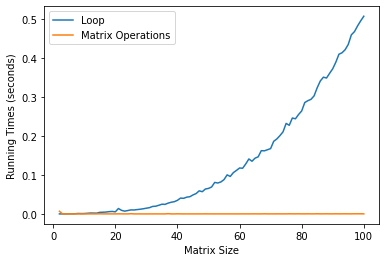

In [6]:
dc = distance_comparison(100)

As we can tell, the vectorized (matrix operations-based) function's running time is very low, and remains approximately constant as the size of the matrix grows. The loop-based function, on the other hand, grows quickly, and soon becomes rather unwieldy – we will see an instance of this when comparing running times on larger datasets in problem 03.

To compare the order-of-magnitude difference between the running times of the functions, let's plot the logs of their quotients at each matrix size:

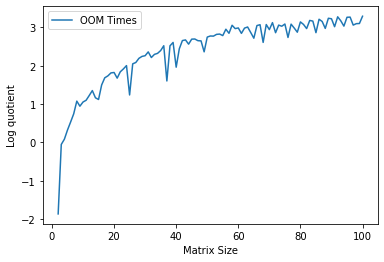

In [7]:
oom_times_loop = [math.log(x/y, 10) for x, y in zip(dc[0], dc[1])]
size = 100
sizes = [i for i in range(2, size + 1)]

plt.xlabel('Matrix Size')
plt.ylabel('Log quotient')
plt.plot(sizes, oom_times_loop, label='OOM Times')
#plt.plot(sizes, mat_ops_times, label='Matrix Operations')
plt.legend()
plt.savefig('comparison-problem-01-logs.png')
plt.show()


Now let's move on to the second problem.

## Problem 02

The second problem requires us to compute the correlation matrix of a matrix consisting of data represented as the row vectors of the matrix. There are again the same two subproblems:

1. Compute the correlation matrix using a loop-based method

2. Compute thee correlation matrix using matrix operations

For the first subproblem, we will also implement two helper functions, `covar` and `sd`, which compute the covariance at a given position and standard deviation of a column vector at a given index, respectively.

In [10]:
def variance_(x, position: Tuple[int, int]):
    num_vectors = x.shape[0]
    """sample_mean = np.zeros(num_vectors)
    for i in range(num_vectors):
        sample_mean += x[:, i]
    sample_mean /= num_vectors"""
    sample_mean = 0
    for i in range(num_vectors):
        sample_mean += x[i][position[1]]
    sample_mean /= num_vectors
    s = 0
    for i in range(num_vectors):
        s += (x[i][position[0]] - sample_mean) * (x[i][position[1]] - sample_mean)
    payload = s/num_vectors
    return payload

In [8]:
def sd(x, idx):
    return math.sqrt(covar(x, (idx, idx)))

Just like in the last problem, we will compare relative orders of magnitude by first initializing variables to store the running times:

In [10]:
corr_loop_times = []
corr_ops_times = []

In [5]:
def compute_correlation_matrix_loop(x):
    feature_dim = x.shape[1]
    z = np.zeros((feature_dim, feature_dim))
    for i in range(feature_dim):
        for j in range(feature_dim):
            if (sd_i := sd(x, i) != 0) and (sd_j := sd(x, j) != 0):
                z[i][j] = variance_(x, (i, j)) / (sd_i * sd_j)
            else:
                z[i][j] = 0
    return z

In [12]:
def compute_correlation_matrix_ops(x):
    num_vectors = x.shape[0]
    y = np.subtract(x, np.divide(np.matmul(np.ones((num_vectors, num_vectors)), x), num_vectors))
    vcv = np.divide(np.matmul(np.transpose(y), y), num_vectors)
    try:
        d = np.linalg.inv(np.sqrt(np.diag(np.diag(vcv))))
    except:
        d = np.zeros(vcv.shape)
    corr_matrix = np.matmul(np.matmul(d, vcv), d)
    return corr_matrix

And again we will plot a comparison of the running times, this time using a function called `correlation_comparison` and with user-input size:

In [13]:
def correlation_comparison(size=None):
    if size is None:
        size = int(input('Up to what size matrix (integer greater than 1) would you like to compare? '))

    assert size > 1
    sizes = [i for i in range(2, size + 1)]
    loop_times = []
    mat_ops_times = []

    for i in tqdm(range(2, size + 1)):
        r = rand(i, i)

        loop_time = timeit(lambda: compute_correlation_matrix_loop(r), number=1)
        mat_ops_time = timeit(lambda: compute_correlation_matrix_ops(r), number=1)

        loop_times.append(loop_time)
        mat_ops_times.append(mat_ops_time)

    plt.xlabel('Matrix Size')
    plt.ylabel('Running Times (seconds)')
    plt.plot(sizes, loop_times, label='Loop')
    plt.plot(sizes, mat_ops_times, label='Matrix Operations')
    plt.legend()
    plt.savefig('comparison-problem-02.png')
    plt.show()
    return loop_times, mat_ops_times

And run it:

100%|██████████| 99/99 [01:46<00:00,  1.08s/it] 


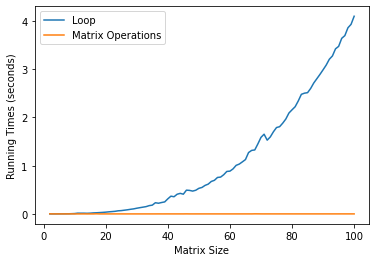

In [14]:
cc = correlation_comparison(100)

The running time of the correlation matrix loop-based function is approximately one order of magnitude greater than the running time of the pairwise distance matrix loop-based function. Again, the vectorized function (shown in orange) has a quite stable running time as the size of the matrix grows.

Like in problem 01, we will compare the orders of magnitude between the running time of the loop method and the matrix operations method:

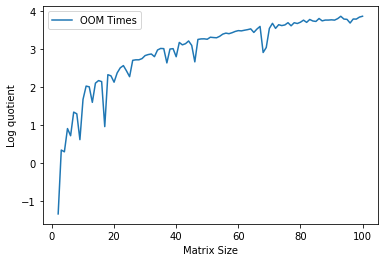

In [15]:
oom_times_corr = [math.log(x/y, 10) for x, y in zip(cc[0], cc[1])]
size = 100
sizes = [i for i in range(2, size + 1)]

plt.xlabel('Matrix Size')
plt.ylabel('Log quotient')
plt.plot(sizes, oom_times_corr, label='OOM Times')
#plt.plot(sizes, mat_ops_times, label='Matrix Operations')
plt.legend()
plt.savefig('comparison-problem-02-logs.png')
plt.show()

The OOM-difference becomes enormous.

Let's plot the difference between loop computations and the difference between matrix operations computations, grouped by problem:

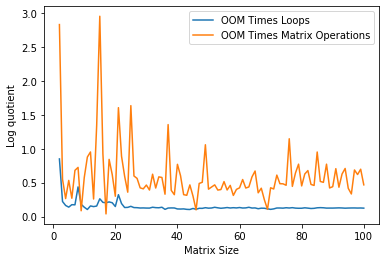

In [16]:
loop_times_both = (dc[0], cc[0])
ops_times_both = (dc[1], cc[1])
sizes = [i for i in range(2, 101)]

oom_times_loop = [x/y for x, y in zip(dc[0], cc[0])]
oom_times_ops = [x/y for x, y in zip(dc[1], cc[1])]

plt.xlabel('Matrix Size')
plt.ylabel('Log quotient')
plt.plot(sizes, oom_times_loop, label='OOM Times Loops')
plt.plot(sizes, oom_times_ops, label='OOM Times Matrix Operations')
plt.legend()
plt.savefig('comparison-problem-types-logs.png')
plt.show()

Now let's move on to problem 03, where we run the algorithms on imported datasets.

## Problem 03

We are running each function on the built-in scikit-learn datasets `iris`, `breast_cancer`, and `digits`. We will output a table of running times.

In [17]:
iris_data = load_iris(as_frame=True).data.to_numpy()
breast_cancer_data = load_breast_cancer(as_frame=True).data.to_numpy()
digits_data = load_digits(as_frame=True).data.to_numpy()

print(iris_data.shape)
print(breast_cancer_data.shape)
print(digits_data.shape)

(150, 4)
(569, 30)
(1797, 64)


We are working with matrices sized $150\times 4$, $569\times 30$, and $1797\times 64$.

We can compute the running times of each function on the loaded datasets as we did previously:

In [18]:

iris_pairwise_distance_loop_time = timeit(lambda: compute_pairwise_distance_loop(iris_data), number=1)
print(iris_pairwise_distance_loop_time)
iris_pairwise_distance_ops_time = timeit(lambda: compute_pairwise_distance_ops(iris_data), number=1)
print(iris_pairwise_distance_ops_time)
iris_correlation_matrix_loop_time = timeit(lambda: compute_correlation_matrix_loop(iris_data), number=1)
print(iris_correlation_matrix_loop_time)
iris_correlation_matrix_ops_time = timeit(lambda: compute_correlation_matrix_ops(iris_data), number=1)
print(iris_correlation_matrix_ops_time)

breast_cancer_pairwise_distance_loop_time = timeit(lambda: compute_pairwise_distance_loop(breast_cancer_data), number=1)
print(breast_cancer_pairwise_distance_loop_time)
breast_cancer_pairwise_distance_ops_time = timeit(lambda: compute_pairwise_distance_ops(breast_cancer_data), number=1)
print(breast_cancer_pairwise_distance_ops_time)
breast_cancer_correlation_matrix_loop_time = timeit(lambda: compute_correlation_matrix_loop(breast_cancer_data), number=1)
print(breast_cancer_correlation_matrix_loop_time)
breast_cancer_correlation_matrix_ops_time = timeit(lambda: compute_correlation_matrix_ops(breast_cancer_data), number=1)
print(breast_cancer_correlation_matrix_ops_time)


digits_pairwise_distance_loop_time = timeit(lambda: compute_pairwise_distance_loop(digits_data), number=1)
print(digits_pairwise_distance_loop_time)
digits_pairwise_distance_ops_time = timeit(lambda: compute_pairwise_distance_ops(digits_data), number=1)
print(digits_pairwise_distance_ops_time)

digits_correlation_matrix_loop_time = timeit(lambda: compute_correlation_matrix_loop(digits_data), number=1)
print(digits_correlation_matrix_loop_time)
digits_correlation_matrix_ops_time = timeit(lambda: compute_correlation_matrix_ops(digits_data), number=1)
print(digits_correlation_matrix_ops_time)


0.1427980219999938
0.0008434840000006716
0.010067670000012185
0.00030666700000381297
5.955928212000003
0.01075855499999534
2.2296578849999946
0.0016349199999865505
111.77037945000001
0.10032650700000545


<ipython-input-11-b019d9ce2182>:7: RuntimeWarning: divide by zero encountered in true_divide
  z[i][j] = covar_ / (sd(x, i) * sd(x, j))


29.54047390300002
0.01154760700001134


And now write the distance and correlation matrices:

In [19]:
distance_matrix = [
    [iris_pairwise_distance_loop_time, iris_pairwise_distance_ops_time],
    [breast_cancer_pairwise_distance_loop_time, breast_cancer_pairwise_distance_ops_time],
    [digits_pairwise_distance_loop_time, digits_pairwise_distance_ops_time]
]

correlation_matrix = [
    [iris_correlation_matrix_loop_time, iris_correlation_matrix_ops_time],
    [breast_cancer_correlation_matrix_loop_time, breast_cancer_correlation_matrix_ops_time],
    [digits_correlation_matrix_loop_time, digits_correlation_matrix_ops_time]
]

print('Distance Matrix Running Times:\n\n')
for i, row in enumerate(distance_matrix):
    print(row)
print('\n\n================\n\nCorrelation Matrix Running Times:\n\n')
for i, row in enumerate(correlation_matrix):
    print(row)
    
print("""\n\n================\n\nWith schema:\n\n
    [iris_loop_time, iris_ops_time]
    [breast_cancer_loop_time, breast_cancer_ops_time]
    [digits_loop_time, digits_ops_time]\n\n""")

Distance Matrix Running Times:


[0.1427980219999938, 0.0008434840000006716]
[5.955928212000003, 0.01075855499999534]
[111.77037945000001, 0.10032650700000545]



Correlation Matrix Running Times:


[0.010067670000012185, 0.00030666700000381297]
[2.2296578849999946, 0.0016349199999865505]
[29.54047390300002, 0.01154760700001134]



With schema:


    [iris_loop_time, iris_ops_time]
    [breast_cancer_loop_time, breast_cancer_ops_time]
    [digits_loop_time, digits_ops_time]




We may also want to view this as a bar chart. Distance bar chart:

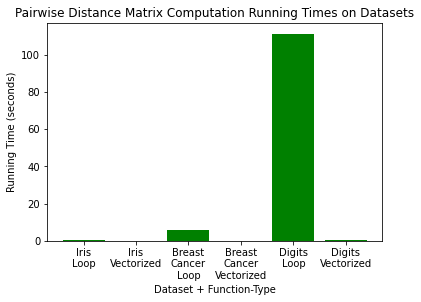

In [20]:
distance_x_labels = ['Iris\nLoop', 'Iris\nVectorized', 'Breast\nCancer\nLoop', 'Breast\nCancer\nVectorized', 'Digits\nLoop', 'Digits\nVectorized']

distance_x_positions = [i for i, x in enumerate(distance_x_labels)]

distance_x_values = [
    iris_pairwise_distance_loop_time, iris_pairwise_distance_ops_time,
    breast_cancer_pairwise_distance_loop_time, breast_cancer_pairwise_distance_ops_time,
    digits_pairwise_distance_loop_time, digits_pairwise_distance_ops_time
]

# distance bar chart
plt.bar(distance_x_positions, distance_x_values, color='green')
plt.xlabel('Dataset + Function-Type')
plt.ylabel('Running Time (seconds)')
plt.title('Pairwise Distance Matrix Computation Running Times on Datasets')
plt.xticks(distance_x_positions, distance_x_labels)
plt.show()

And correlation bar chart:

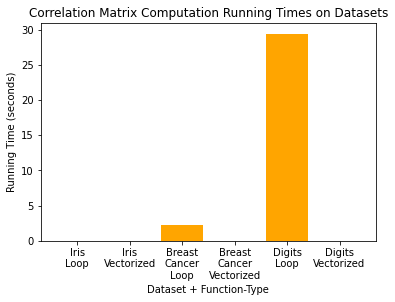

In [21]:
correlation_x_labels = ['Iris\nLoop', 'Iris\nVectorized', 'Breast\nCancer\nLoop', 'Breast\nCancer\nVectorized', 'Digits\nLoop', 'Digits\nVectorized']

correlation_x_positions = [i for i, x in enumerate(correlation_x_labels)]

correlation_x_values = [
    iris_correlation_matrix_loop_time, iris_correlation_matrix_ops_time,
    breast_cancer_correlation_matrix_loop_time, breast_cancer_correlation_matrix_ops_time,
    digits_correlation_matrix_loop_time, digits_correlation_matrix_ops_time
]

# correlation bar chart
plt.bar(correlation_x_positions, correlation_x_values, color='orange')
plt.xlabel('Dataset + Function-Type')
plt.ylabel('Running Time (seconds)')
plt.title('Correlation Matrix Computation Running Times on Datasets')
plt.xticks(correlation_x_positions, correlation_x_labels)
plt.show()